In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

theme, cs = rp.mpl_setup(False)

In [2]:
!ls exps/

delta_e_02-04-15-04/             delta_e_02-27-12-11/
delta_e_02-04-long/              delta_e_02-27-16-46/
delta_e_02-05-13-23/             delta_e_02-27-18-16/
delta_e_02-05-13-25/             delta_e_04-22-10-51/
delta_e_02-05-better-hopefully/  delta_e_04-22-11-28/
delta_e_02-12-13-31/             delta_e_04-22-11-29/
delta_e_02-12-13-42/             delta_e_04-22-11-30/
delta_e_02-12-13-45/             delta_e_04-22-11-31/
delta_e_02-12-13-46/             delta_e_04-22-11-32/
delta_e_02-12-13-50/             delta_e_04-22-11-44/
delta_e_02-12-13-51/             delta_e_04-22-12-41/
delta_e_02-19-13-22/             delta_e_04-22-12-46/
delta_e_02-19-13-30/             delta_e_04-22-13-25/
delta_e_02-19-13-31/             delta_e_04-22-13-26/
delta_e_02-19-13-33/             delta_e_04-22-13-27/
delta_e_02-19-13-35/             delta_e_04-22-13-30/
delta_e_02-19-13-42/             delta_e_04-25-17-15/
delta_e_02-19-13-46/             delta_e_04-25-17-26/
delta_e_02-19-13-47/        

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


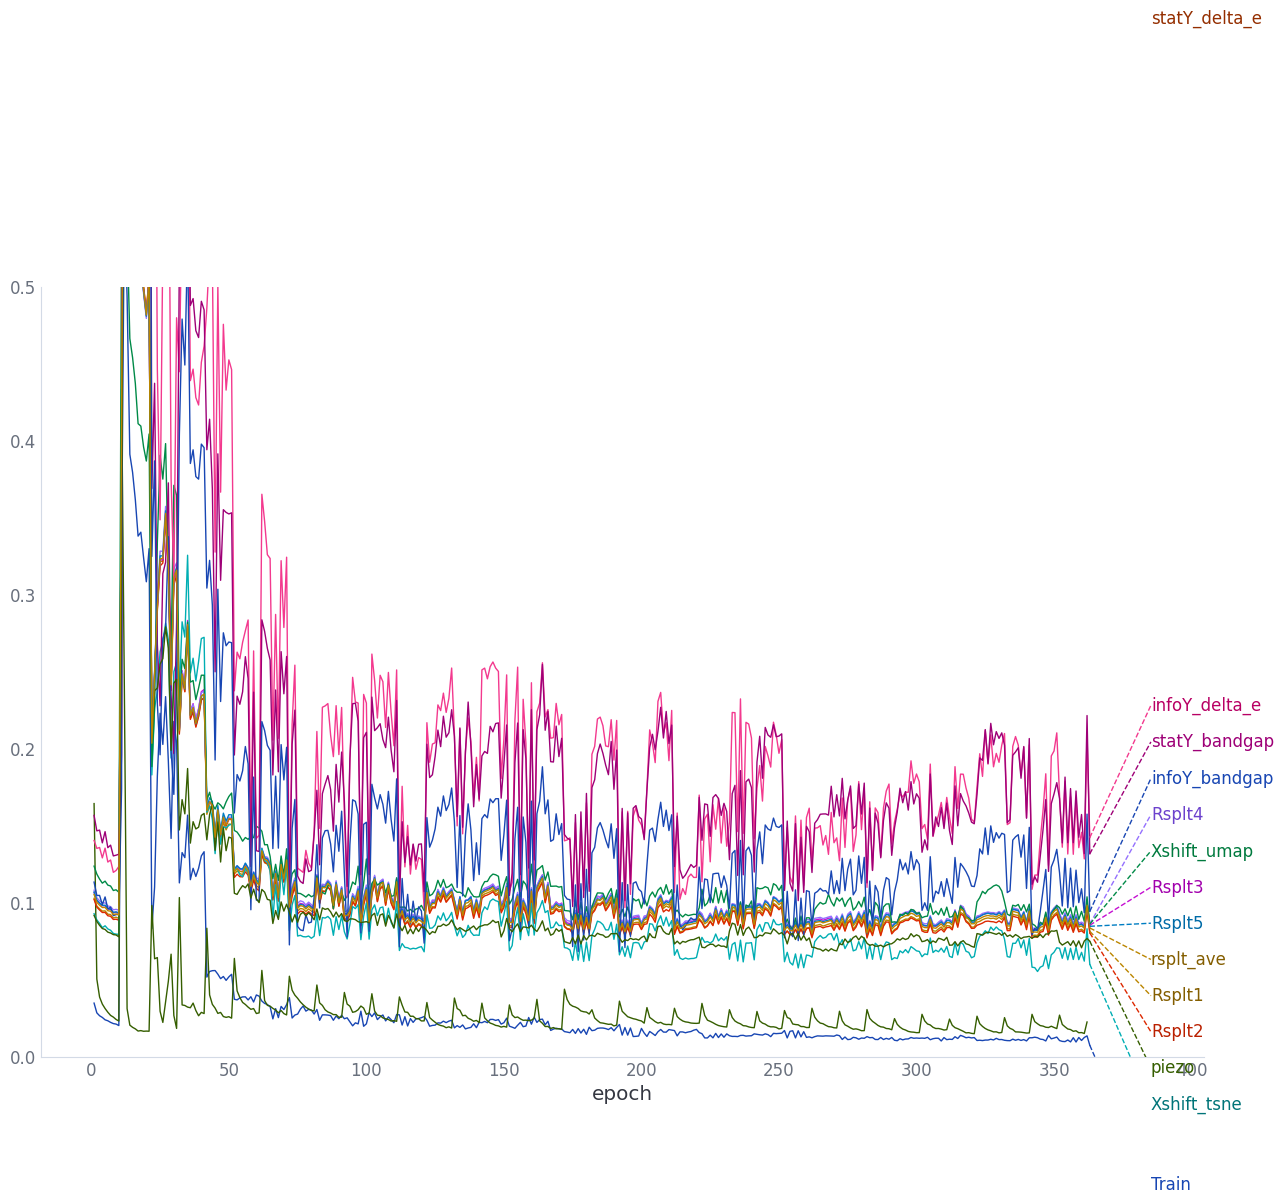

In [11]:
def plot_logs(name):
    fig, ax = plt.subplots(figsize=(15, 10))
    df = pd.read_feather(f'exps/{name}/SAL-training_loss.feather')
    # df = df.drop(columns=['statY_delta_e'])
    df.set_index('epoch').plot(ax=ax, lw=1)
    ax.set_ylim(0, 0.5)
    # rp.smooth_noisy_lines(keep_old_line=False)
    # rp.smooth_straight_lines
    # for i in range(2, max(df.index), 3):
    #     ax.axvline(i, lw=0.5, alpha=0.5, color='grey')
    rp.line_labels()
    return df
# df.set_index('epoch').map(lambda x: np.log10(x + 1)).plot(ax=ax, alpha=0.05, lw=0.2, legend=None)

df1 = plot_logs('delta_e_baseline_attempt4')

In [13]:
df1.to_csv('new_baseline.csv')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


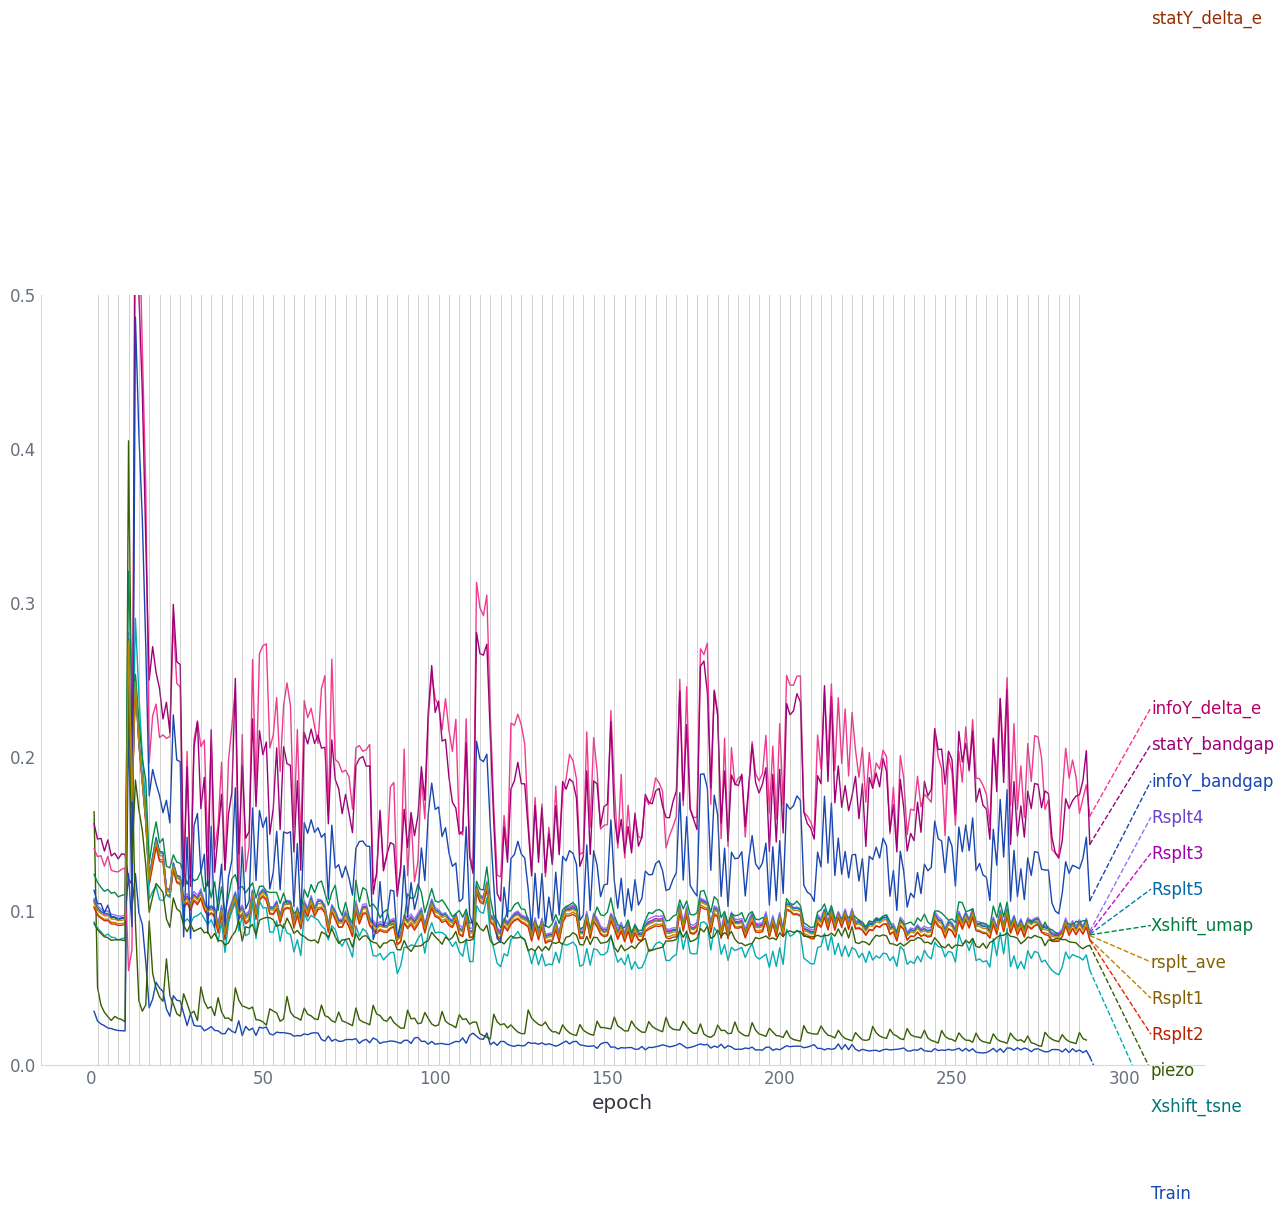

In [8]:
df2 = plot_logs('delta_e_05-14-11-47')

In [9]:
df2

,epoch,Train,Partial_train,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,Xshift_tsne,Xshift_umap,statY_delta_e,infoY_delta_e,statY_bandgap,infoY_bandgap,piezo,rsplt_ave,Partial
0,1,0.034715,0.164271,0.102765,0.102031,0.106452,0.108030,0.106872,0.092764,0.123653,0.691778,0.140333,0.156589,0.113302,0.091667,0.105230,NaN
1,2,0.028391,0.050317,0.097718,0.097023,0.101424,0.103113,0.101577,0.088762,0.118496,0.687930,0.135183,0.146572,0.104617,0.087734,0.100171,NaN
2,3,0.026510,0.038649,0.095945,0.095165,0.099448,0.101209,0.099720,0.086470,0.115253,0.684378,0.135769,0.147040,0.104634,0.085189,0.098297,NaN
3,4,0.025408,0.034084,0.094484,0.093560,0.097961,0.099736,0.098228,0.083687,0.112614,0.681039,0.129008,0.138776,0.098714,0.083151,0.096794,NaN
4,5,0.023866,0.031210,0.094608,0.093597,0.097948,0.099813,0.098274,0.084923,0.113921,0.688442,0.135355,0.146050,0.103655,0.082544,0.096848,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,286,0.008536,0.013756,0.084945,0.084438,0.088540,0.090147,0.087933,0.070552,0.093177,0.678521,0.187033,0.174471,0.128540,0.079219,0.087200,NaN
286,287,0.009619,0.020971,0.088683,0.088477,0.093030,0.094266,0.092454,0.069763,0.092675,0.698734,0.163283,0.175343,0.127307,0.076866,0.091382,NaN
287,288,0.007865,0.016982,0.085178,0.084829,0.089186,0.089961,0.088914,0.068060,0.093456,0.670572,0.172822,0.184429,0.133965,0.075311,0.087614,NaN
288,289,0.009289,0.016054,0.090052,0.089453,0.094160,0.095093,0.093864,0.071350,0.093727,0.699064,0.181765,0.203974,0.147790,0.076902,0.092524,NaN


In [10]:
df2.to_csv('new_baseline.csv')

In [6]:
df2.drop(columns=['Partial']).to_csv('datacopy.csv')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


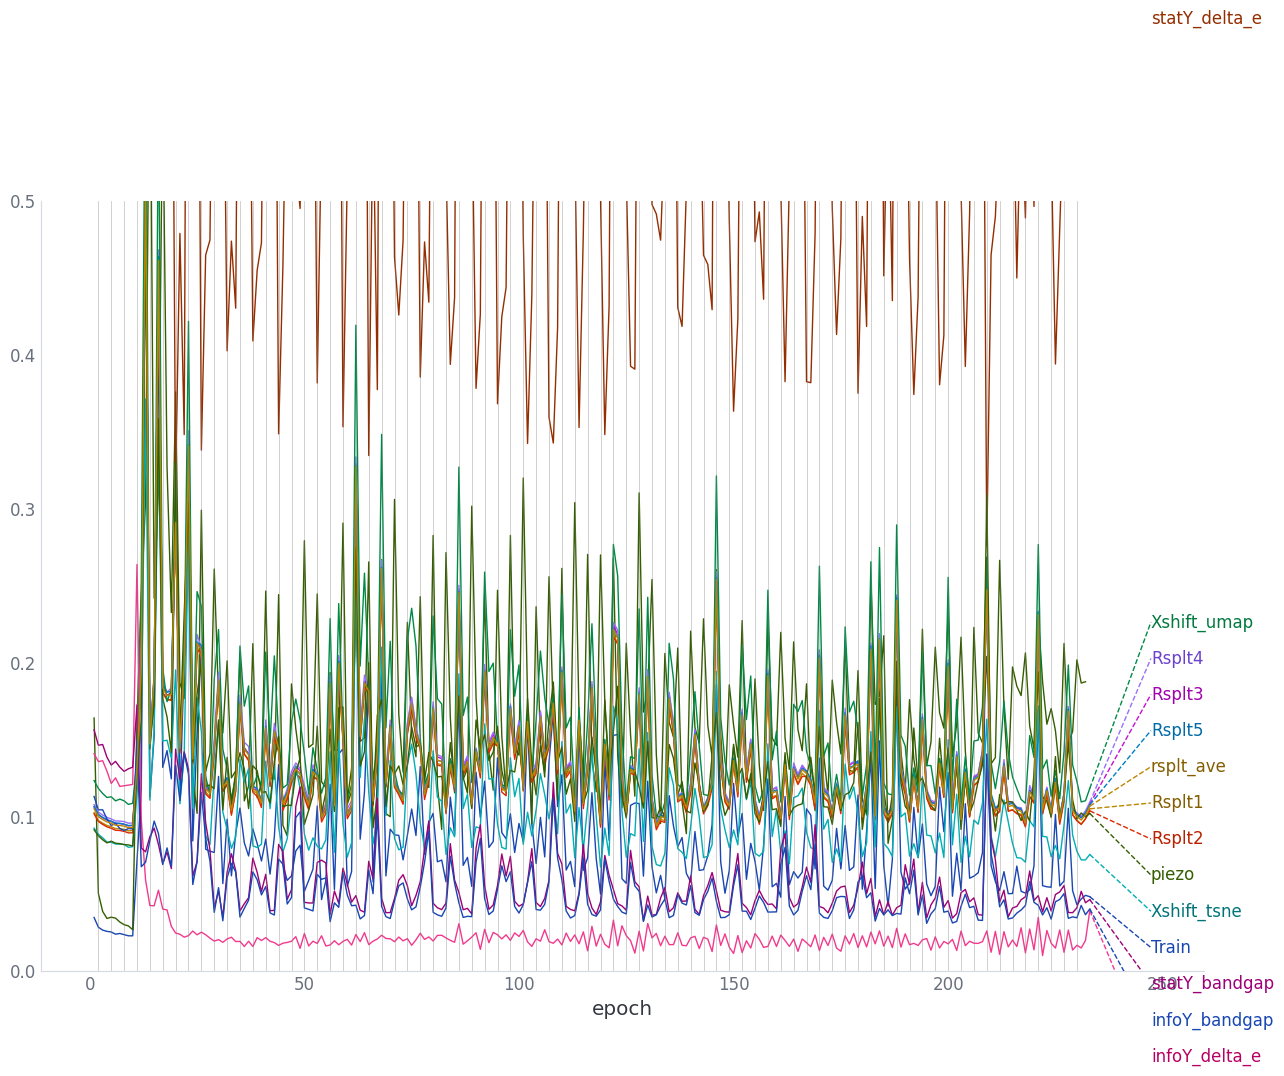

In [7]:
dfp = plot_logs('delta_e_info_y')

In [6]:
dfp

NameError: name 'dfp' is not defined

In [4]:
data = pd.read_feather('mpc_full_feats_scaled_split.feather')

data

,comp,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,minimum Number,maximum Number,range Number,...,infoY_delta_e,statY_bandgap,infoY_bandgap,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,piezo,dataset_split
0,In1,-2.544139,4.304959,4.099305,3.846319,3.738150,3.663704,2.864847,0.010989,-1.760193,...,False,False,False,False,False,False,False,False,False,1
1,Mg1,-2.544139,4.304959,4.099305,3.846319,3.738150,3.663704,-0.041846,-1.664706,-1.760193,...,False,False,False,False,True,False,False,True,False,0
2,Be1,-2.544139,4.304959,4.099305,3.846319,3.738150,3.663704,-0.670320,-2.027018,-1.760193,...,False,False,False,False,False,False,False,False,False,2
3,Hf1,-2.544139,4.304959,4.099305,3.846319,3.738150,3.663704,4.671710,1.052637,-1.760193,...,False,False,False,False,False,False,False,False,False,1
4,P1,-2.544139,4.304959,4.099305,3.846319,3.738150,3.663704,0.193832,-1.528839,-1.760193,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84185,Sb2W1O6,-0.302404,0.587564,0.680144,0.747711,0.764994,0.771629,-0.356083,1.143215,1.446811,...,False,False,False,False,False,False,False,False,True,0
84186,Sr1Hf1O3,-0.302404,-0.032556,0.033257,0.130844,0.170592,0.193219,-0.356083,1.052637,1.349629,...,False,False,False,False,False,False,False,False,True,1
84187,Rb1Ta1O3,-0.302404,-0.032556,0.033257,0.130844,0.170592,0.193219,-0.356083,1.097926,1.398220,...,False,False,False,False,False,False,False,False,True,1
84188,Ba1Ni1O3,-0.302404,-0.032556,0.033257,0.130844,0.170592,0.193219,-0.356083,0.328012,0.572174,...,False,False,False,False,False,False,False,False,True,0


In [9]:
iy = data[data['infoY_delta_e']]
iy

,comp,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,minimum Number,maximum Number,range Number,...,infoY_delta_e,statY_bandgap,infoY_bandgap,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,piezo,dataset_split
230,Gd1O1,-1.423272,0.531502,0.196697,-0.117173,-0.257899,-0.363061,-0.356083,0.690325,0.960902,...,True,False,False,True,False,False,False,False,False,1
615,Nd1O1,-1.423272,0.531502,0.196697,-0.117173,-0.257899,-0.363061,-0.356083,0.509169,0.766538,...,True,False,False,False,False,True,False,False,False,3
867,Mg1O1,-1.423272,0.531502,0.196697,-0.117173,-0.257899,-0.363061,-0.356083,-1.664706,-1.565830,...,True,True,True,False,False,False,False,False,False,1
921,Ca1O1,-1.423272,0.531502,0.196697,-0.117173,-0.257899,-0.363061,-0.356083,-1.302393,-1.177102,...,True,False,True,False,False,False,True,False,False,0
967,Na1F1,-1.423272,0.531502,0.196697,-0.117173,-0.257899,-0.363061,-0.277523,-1.709995,-1.663012,...,True,True,True,False,False,False,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83771,Ca2Zr5Ti2O16,0.818464,0.182275,0.379157,0.497762,0.526957,0.540257,-0.356083,-0.396612,-0.205282,...,True,False,False,True,False,False,False,False,False,1
83785,Rb7U8V2Cl1O32,1.939331,0.129064,0.361388,0.495902,0.526788,0.540253,-0.356083,1.958418,2.321449,...,True,False,False,False,True,False,False,False,False,0
83794,Ba5B4O11,-0.302404,-0.379491,-0.384105,-0.317784,-0.272747,-0.240412,-0.591761,0.328012,0.717947,...,True,False,True,True,False,False,False,True,False,2
83802,Ca3Al2O6,-0.302404,-0.379909,-0.399247,-0.350802,-0.310960,-0.279578,-0.356083,-1.302393,-1.177102,...,True,False,True,False,False,False,False,False,False,0


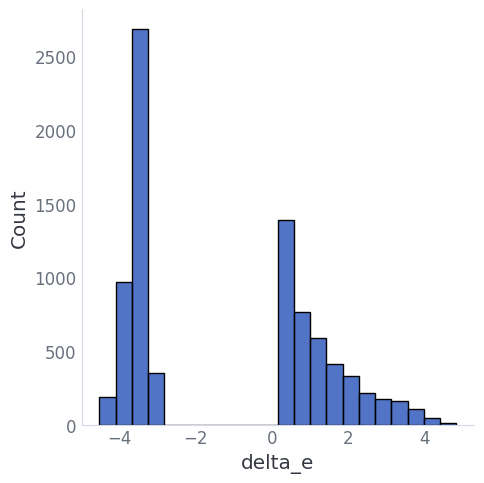

In [10]:
sns.displot(data.query('statY_delta_e')['delta_e'])

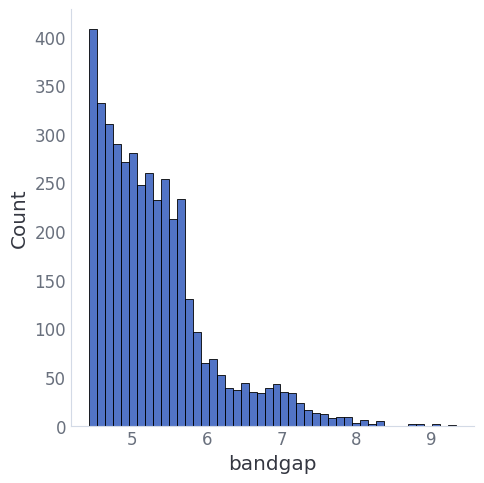

In [13]:
sns.displot(data.query('statY_bandgap')['bandgap'])

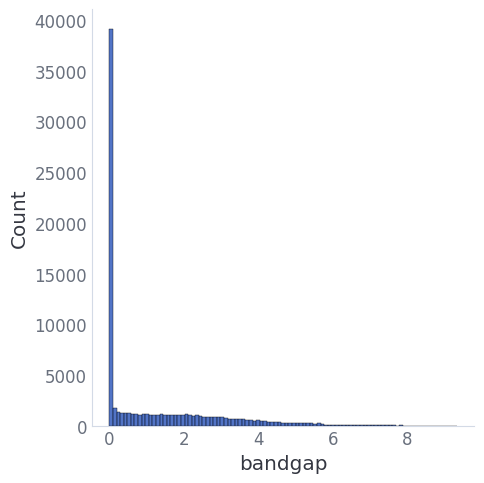

In [13]:
sns.displot(data['bandgap'])

In [15]:
np.mean(np.abs(data['delta_e'] - np.median(data['delta_e'])))

1.0466926

In [14]:
np.mean(np.abs(iy['delta_e'] - np.median(iy['delta_e'])))

0.2380495

In [10]:
import torch
from glob import glob
import torch.nn as nn
class IRNet_intorch(torch.nn.Module):
    #'128-64-16'
    def __init__(self, input_size):
        super(IRNet_intorch, self).__init__()
        self.fc128 = nn.Linear(128, 128)
        self.fc64 = nn.Linear(64, 64)
        self.fc16 = nn.Linear(16, 16)

        self.bn128 = nn.BatchNorm1d(128)
        self.bn64 = nn.BatchNorm1d(64)
        self.bn16 = nn.BatchNorm1d(16)

        self.relu = nn.ReLU()
        self.inputlayer = nn.Linear(input_size, 128)

        self.con128_64 = nn.Linear(128, 64)
        self.con64_16 = nn.Linear(64, 16)
        self.output16 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.inputlayer(x)

        x_res = x
        x = self.fc128(x)
        x = self.bn128(x)
        x = self.relu(x)
        x = x + x_res
        x = self.con128_64(x)

        x_res = x
        x = self.fc64(x)
        x = self.bn64(x)
        x = self.relu(x)
        x = x + x_res
        x = self.con64_16(x)

        x_res = x
        x = self.fc16(x)
        x = self.bn16(x)
        x = self.relu(x)
        x = x + x_res

        x = self.output16(x)
        return x

def get_params(model: IRNet_intorch):
    return model.inputlayer.weight.mean(dim=0).abs()

epochs = []
weights = []

with torch.no_grad():
    for name in glob('exps/delta_e_02-23-14-26/models/IR3_epoch_*.pt'):
        epoch = int(name.removesuffix('.pt').split('_')[-1])
        model = torch.load(name)

        weights.append(get_params(model))
        epochs.append(epoch)

    epochs = torch.tensor(epochs)
    weights = torch.stack(weights)

    weights = weights[torch.argsort(epochs)]
    epochs = epochs[torch.argsort(epochs)]

In [12]:
model = IRNet_intorch(145)

In [14]:
list(model.named_parameters())

[('fc128.weight',
  Parameter containing:
  tensor([[ 0.0536,  0.0339,  0.0728,  ...,  0.0180, -0.0766,  0.0620],
          [ 0.0120,  0.0017,  0.0661,  ...,  0.0542, -0.0040, -0.0556],
          [-0.0277, -0.0827,  0.0277,  ...,  0.0728,  0.0447,  0.0463],
          ...,
          [-0.0019, -0.0703, -0.0640,  ..., -0.0883, -0.0269, -0.0103],
          [ 0.0581,  0.0271,  0.0004,  ..., -0.0815, -0.0440,  0.0081],
          [ 0.0713,  0.0573,  0.0362,  ...,  0.0724,  0.0737,  0.0865]],
         requires_grad=True)),
 ('fc128.bias',
  Parameter containing:
  tensor([ 0.0204, -0.0615,  0.0022, -0.0406, -0.0761,  0.0049, -0.0685, -0.0029,
           0.0161, -0.0117,  0.0423, -0.0108,  0.0617, -0.0474, -0.0748,  0.0782,
          -0.0760, -0.0531, -0.0421, -0.0596, -0.0457,  0.0717, -0.0198, -0.0402,
          -0.0434,  0.0858,  0.0840,  0.0757,  0.0848,  0.0573,  0.0640,  0.0806,
           0.0233, -0.0057, -0.0073,  0.0422, -0.0442, -0.0670,  0.0700, -0.0259,
           0.0851,  0.0434,  

In [ ]:
from src.utils import to_np

w = to_np(weights)

data = pd.read_feather('mpc_full_feats_scaled_split.feather')
cols = data.columns[1:146]

wdf = pd.DataFrame(w, columns=cols, index=to_np(epochs))
wdf.head()

In [ ]:
high_var_cols = wdf.std(axis=0).sort_values()[::-1].head(10).index
wdf[high_var_cols].plot()
rp.line_labels()

In [ ]:
salw = torch.tensor([7.5641e+03, 1.1149e+04, 8.8050e+03, 6.5502e+03, 4.8011e+03, 4.9787e+03,
        4.8674e+03, 4.2974e+03, 5.3753e+03, 5.7287e+03, 8.2724e+03, 6.1718e+03,
        8.6208e+03, 1.0240e+04, 1.0027e+04, 8.8002e+03, 8.2256e+03, 1.0730e+04,
        6.7404e+03, 4.3592e+03, 5.1032e+03, 6.5154e+03, 7.3106e+03, 7.6345e+03,
        9.8441e+03, 1.1520e+04, 1.1624e+04, 9.4132e+03, 1.6377e+04, 7.7563e+03,
        1.0531e+04, 1.3742e+04, 1.0908e+04, 8.2601e+03, 1.1363e+04, 8.5690e+03,
        5.0495e+03, 1.2681e+04, 7.7252e+03, 5.6099e+03, 9.2453e+03, 8.2575e+03,
        6.2180e+03, 1.2382e+04, 1.6208e+04, 1.2909e+04, 1.6645e+04, 9.2930e+03,
        8.8939e+03, 1.7135e+04, 1.5762e+04, 1.4742e+04, 2.3940e+04, 8.8418e+03,
        6.7326e+03, 4.1118e+03, 8.9933e+03, 7.1492e+03, 8.0763e+03, 7.9999e+03,
        9.1089e+03, 1.0422e+04, 1.4567e+04, 1.0887e+04, 1.0490e+04, 6.1870e+03,
        1.2594e+04, 8.3835e+03, 8.5477e+03, 9.1938e+03, 1.3445e+04, 1.1119e+04,
        4.0550e+03, 7.0541e+03, 5.7408e+03, 6.8563e+03, 1.0000e+00, 7.5973e+03,
        1.0036e+04, 1.2485e+04, 1.3248e+04, 3.6473e+03, 1.3025e+04, 1.2059e+04,
        4.1526e+03, 7.2269e+03, 9.6384e+03, 9.1124e+03, 9.7935e+03, 1.0412e+04,
        7.6082e+03, 1.0772e+04, 1.0111e+04, 1.3794e+04, 2.2914e+04, 1.0869e+04,
        5.6140e+03, 7.3420e+03, 8.1755e+03, 8.1320e+03, 1.5337e+04, 9.7747e+03,
        1.5417e+03, 1.1578e+04, 1.2958e+04, 1.0241e+04, 1.4827e+04, 1.3336e+04,
        2.4689e+04, 1.5316e+04, 1.4966e+04, 2.2873e+04, 1.8989e+04, 1.5432e+04,
        1.1321e+04, 8.2973e+03, 9.8889e+03, 1.2825e+04, 1.7342e+04, 1.0677e+04,
        7.1521e+03, 8.5476e+03, 7.2192e+03, 1.1388e+04, 6.5605e+03, 1.1304e+04,
        1.3394e+03, 7.3983e+03, 7.6834e+03, 1.0150e+04, 1.0613e+04, 5.5198e+03,
        8.7780e+03, 2.1204e+04, 9.5088e+03, 1.8393e+04, 7.9973e+03, 7.5481e+03,
        8.4170e+03, 7.5423e+03, 8.8349e+03, 6.8705e+03, 2.2745e+04, 1.5653e+04,
        1.8500e+04], device='cuda:0')

salw = pd.Series(to_np(salw), index=cols)
salw.sort_values()

In [194]:
data_adv = data.query('piezo').iloc[::10, 1:146]
data_adv['epoch'] = -10
data_adv['batch'] = -3

adv = [data_adv]
for name in list(glob('exps/delta_e_02-23-14-26/adv/*.feather'))[::10]:
    epoch, batch = map(int, name.removesuffix('.feather').split('attack')[-1].split('_'))
    adv_file = pd.read_feather(name)
    adv_file['epoch'] = epoch
    adv_file['batch'] = str(batch)
    adv.append(adv_file)


adv = pd.concat(adv).sort_values('epoch').reset_index(drop=True)
adv

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,minimum Number,maximum Number,range Number,mean Number,...,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,epoch,batch,label
0,-0.302404,-0.032556,0.033257,0.130844,0.170592,0.193219,-0.356083,1.550816,1.884130,0.081558,...,0.737291,0.859944,-0.094490,0.720958,1.125155,0.552832,0.613766,-10,-3,NaN
1,-0.302404,0.657163,0.709718,0.751668,0.765488,0.771651,-0.356083,-0.351323,-0.156691,-0.405381,...,-0.757509,0.566738,-0.810118,-0.492369,-0.888766,1.100757,1.293215,-10,-3,NaN
2,-0.302404,-0.044455,-0.237875,-0.441547,-0.531773,-0.589456,-0.748879,-1.030659,-0.642601,-1.123891,...,-1.504909,-0.270992,-0.773606,-0.492369,-0.888766,0.961428,1.565846,-10,-3,NaN
3,-0.302404,-0.688997,-0.766741,-0.752689,-0.712282,-0.673577,0.272391,-0.894792,-1.128511,-0.245204,...,-0.383809,-0.019673,0.116365,-0.492369,-0.888766,-0.651922,-0.631580,-10,-3,NaN
4,-0.302404,-0.688997,-0.766741,-0.752689,-0.712282,-0.673577,2.707728,0.735614,-0.885556,1.901172,...,-0.383809,-0.019673,1.937384,0.482626,1.125155,-0.959843,-0.941618,-10,-3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152610,-0.302404,-1.140201,-1.376947,-1.598701,-1.703648,-1.784628,0.272391,1.279082,1.203856,1.516747,...,0.737291,0.273533,1.234535,1.529842,-0.888766,-1.487461,-1.384442,497,4,-0.576848
152611,-0.302404,-0.355159,-0.526169,-0.710944,-0.805057,-0.879671,0.272391,-0.894792,-1.128511,-0.120622,...,-1.255776,-0.215144,0.851162,-0.492369,-0.888766,-0.905746,-1.002130,497,4,-0.742720
152612,-0.302404,-0.366848,-0.495845,-0.606157,-0.641581,-0.650592,1.293662,-0.351323,-1.177102,0.555683,...,-1.504909,-0.019673,2.608286,-0.492369,-0.888766,-1.025945,-1.042094,497,4,-0.524375
152613,-0.302404,-1.140201,-1.376947,-1.598701,-1.703648,-1.784628,1.215102,1.550816,0.912311,2.221527,...,0.737291,-0.899290,1.362326,2.974279,-0.888766,-1.212133,-1.096381,497,4,-0.697987


In [208]:
(salw / np.sum(salw)).sort_values()

avg_dev NfValence            6.835873e-07
minimum GSmagmom             9.155968e-04
minimum NfUnfilled           1.053886e-03
mean NValence                2.493248e-03
minimum NfValence            2.771946e-03
                                 ...     
compound possible            1.554819e-02
mean NUnfilled               1.563569e-02
avg_dev NpUnfilled           1.566372e-02
avg_dev Electronegativity    1.636508e-02
minimum NUnfilled            1.687709e-02
Length: 145, dtype: float32

In [195]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
reducer = PCA(n_components=2)

adv[['x', 'y']] = reducer.fit_transform(scaler.fit_transform(adv.iloc[:, :145]))

In [196]:
comps = pd.Series(reducer.components_[0], adv.columns[:145])
comps.sort_values()

maximum Electronegativity   -0.150446
max ionic char              -0.145308
range Electronegativity     -0.143576
avg ionic char              -0.135261
avg_dev Electronegativity   -0.133546
                               ...   
mean Number                  0.144760
minimum MeltingT             0.147810
minimum Row                  0.150894
minimum CovalentRadius       0.150986
mean Row                     0.151026
Length: 145, dtype: float32

<Axes: xlabel='epoch', ylabel='x'>

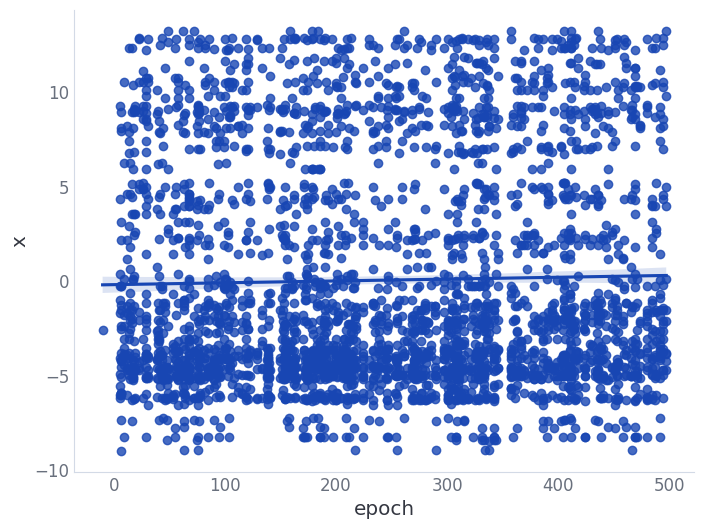

In [197]:
sns.regplot(adv.iloc[::47], x='epoch', y='x')

<Axes: xlabel='x', ylabel='y'>

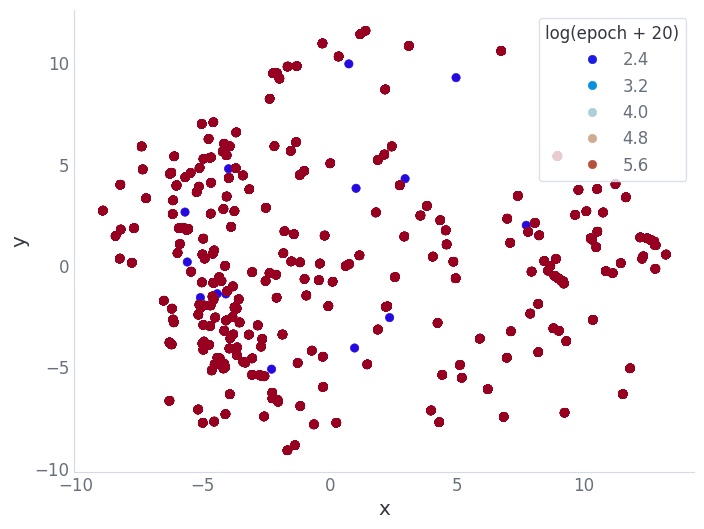

In [201]:
sns.scatterplot(adv.query('epoch % 5 == 1 or epoch < 0'), hue='log(epoch + 20)', palette='rho_diverging', x='x', y='y', ec=None)

<Axes: xlabel='time_iter', ylabel='max ionic char'>

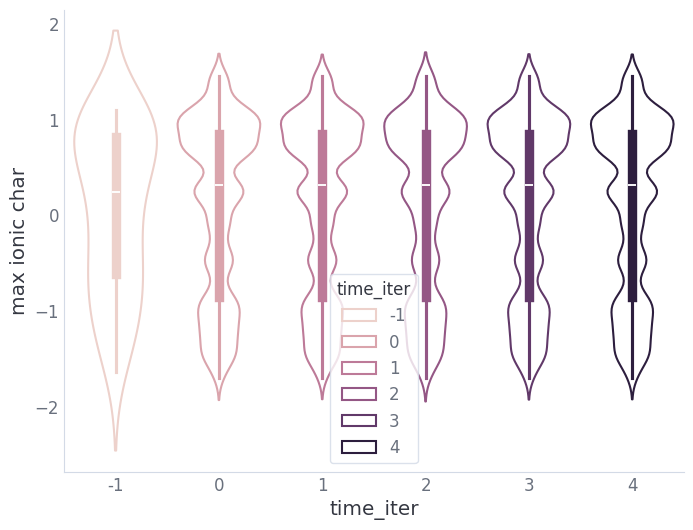

In [214]:
adv['time'] = (adv['epoch'] // 20).astype(str)
adv['time_iter'] = np.where(adv['epoch'] < 0, adv['epoch'] // 10, adv['epoch'] % 5)

sns.violinplot(adv, x='time_iter', y='max ionic char', fill=False, hue='time_iter')

In [218]:
adv.groupby('time_iter').mean(numeric_only=True)

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,minimum Number,maximum Number,range Number,mean Number,...,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,epoch,label,x,y
time_iter,,,,,,,,,,,,,,,,,,,,,
-1,-0.302404,-0.244023,-0.302472,-0.339561,-0.352367,-0.360399,0.171674,0.269949,0.183446,0.249284,...,0.184103,0.152786,0.210731,0.144014,0.048673,0.144401,-10.000000,NaN,0.426584,0.869125
0,-0.302397,-0.242993,-0.300887,-0.344086,-0.362699,-0.376107,0.146886,0.328015,0.261078,0.246237,...,0.220950,0.170617,0.232912,0.283406,0.085684,0.178823,254.298246,-1.712299,-0.000274,-0.000402
1,-0.302403,-0.242992,-0.300890,-0.344094,-0.362705,-0.376109,0.146887,0.328014,0.261080,0.246242,...,0.220951,0.170612,0.232909,0.283407,0.085687,0.178825,262.884058,-1.712299,0.000034,-0.000036
2,-0.302405,-0.242991,-0.300886,-0.344091,-0.362700,-0.376110,0.146887,0.328015,0.261081,0.246244,...,0.220952,0.170610,0.232903,0.283408,0.085687,0.178825,233.785714,-1.712299,0.000045,-0.000035
3,-0.302406,-0.242994,-0.300894,-0.344100,-0.362702,-0.376112,0.146888,0.328010,0.261081,0.246242,...,0.220951,0.170611,0.232900,0.283402,0.085686,0.178823,236.730159,-1.712299,0.000003,-0.000103
4,-0.302405,-0.242994,-0.300893,-0.344102,-0.362701,-0.376116,0.146884,0.328015,0.261084,0.246252,...,0.220940,0.170617,0.232904,0.283405,0.085688,0.178820,250.119403,-1.712299,-0.000317,-0.000490
